In [59]:
from pathlib import Path
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [46]:
folder = Path("")
dataset_file = folder / "tasks_results.json"

with open(dataset_file, 'r') as file:
    task_results = json.load(file)

# convert all tasks and model names to lower
task_results = {key.lower(): {key_in.lower(): value_in for key_in, value_in in value.items()} for key, value in task_results.items()}

In [47]:
def get_models_set(task_dict):
    # get set of models for each task.
    model_dict = {}
    for task, model_scores in task_dict.items():
        model_set = {model.lower() for model in model_scores.keys()}
        model_dict[task] = model_set

    return model_dict

def model_task_count(tasks_dict):
    # Calculate number of tasks, in which models are used
    all_tasks = set(tasks_dict.keys())
    all_tasks.remove('plcc_proj_lev_path_dist_em')
    model_analysis = {}

    for task, model_scores in tasks_dict.items():
        for model in model_scores.keys():
            model_lower = model.lower()
            if model_lower not in model_analysis:
                model_analysis[model_lower] = {
                    "num_tasks": 0,
                    "tasks": set(),
                    "missed_tasks": set()
                }
            model_analysis[model_lower]["num_tasks"] += 1
            model_analysis[model_lower]["tasks"].add(task)

    for model, details in model_analysis.items():
        details["missed_tasks"] = list(all_tasks - details["tasks"])
        details["tasks"] = list(details["tasks"])

    sorted_model_analysis = dict(sorted(model_analysis.items(), key=lambda item: len(item[1]["missed_tasks"]), reverse=False))

    return sorted_model_analysis

def normalize_scores(task_scores: dict) -> dict:
    min_score = min(task_scores.values())
    max_score = max(task_scores.values())
    scaling_factor = max_score - min_score
    normalized_dict = {
        model: (score - min_score) / scaling_factor
        for model, score in task_scores.items()
    }

    return normalized_dict

def filter_common_models(task_results):

    model_count = model_task_count(task_results)
    common_models = set()
    for model, task_info in model_count.items():
        if len(task_info["missed_tasks"]) == 0:
            common_models.add(model)

    task_results_filtered = dict()
    for task, scores in task_results.items():
        filtered_scores = {model: score for model, score in scores.items() if model in common_models}
        if len(filtered_scores) != 0:
            task_results_filtered[task] = filtered_scores

    return task_results_filtered

In [48]:
for task, scores in task_results.items():
    task_results[task] = normalize_scores(scores)

In [49]:
model_dict = get_models_set(task_results)
model_count = model_task_count(task_results)
model_list = sorted(list(model_count.keys()))
task_results_common = filter_common_models(task_results)

In [ ]:
if False:
    with open("model_count.json", "w") as file:
        json.dump(model_count, file, indent=4)
    with open("model_list.txt", "w") as file:
        file.write("\n".join(model_list))

In [54]:
task_results_df = pd.DataFrame(task_results_common)
task_pearson_corr = task_results_df.corr(method='pearson')
task_spearman_corr = task_results_df.corr(method='spearman')

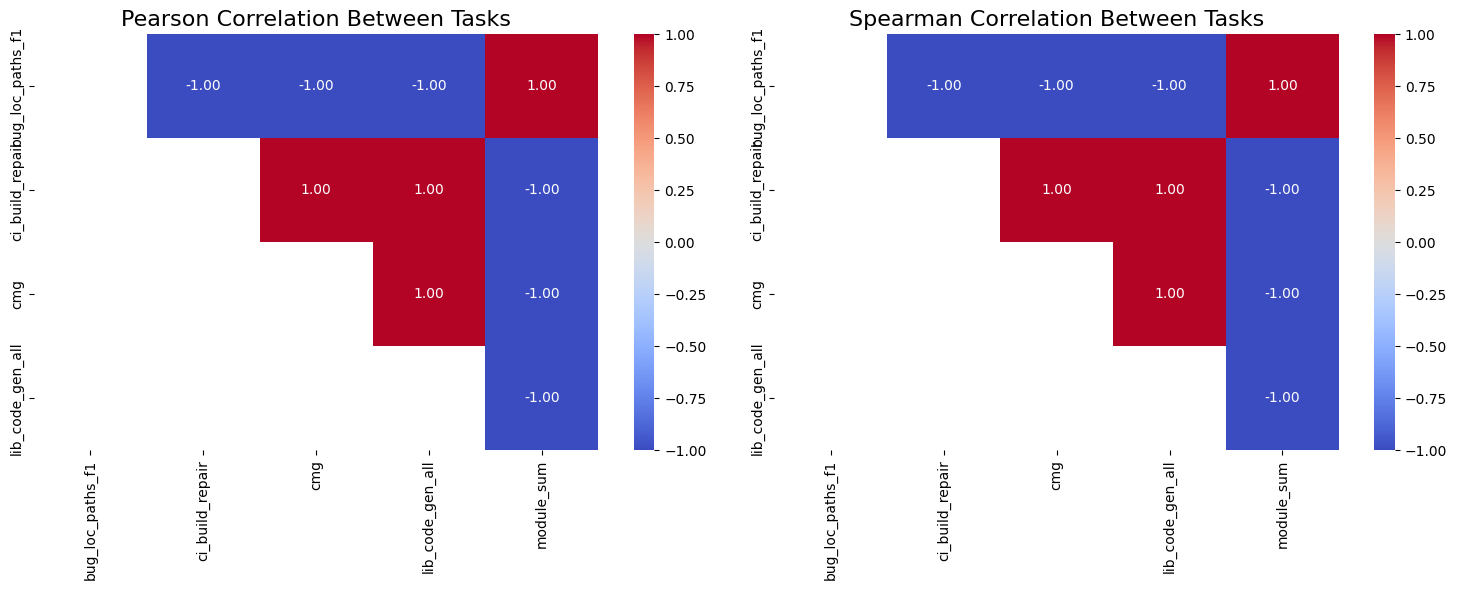

In [69]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
mask = np.triu(np.ones_like(task_pearson_corr), k=0).T
sns.heatmap(task_pearson_corr[:-1], mask=mask[:-1], annot=True, cmap='coolwarm',
            vmin=-1, vmax=1, ax=axes[0], fmt='.2f')
axes[0].set_title('Pearson Correlation Between Tasks', fontsize=16)
sns.heatmap(task_spearman_corr[:-1], mask=mask[:-1], annot=True, cmap='coolwarm',
            vmin=-1, vmax=1, ax=axes[1], fmt='.2f')
axes[1].set_title('Spearman Correlation Between Tasks', fontsize=16)

plt.tight_layout()
plt.show()